In [33]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np

In [34]:
train_set = pd.read_pickle('emoji_train.pkl')
test_set = pd.read_pickle('emoji_test.pkl')

tweets_train = train_set['tweet'].to_list()
emoji_class_train = train_set['emoji_class'].to_list()
tweets_test = test_set['tweet'].to_list()
emoji_class_test = test_set['emoji_class'].to_list()


In [35]:
# frequency of emotes
print(train_set['emoji'].value_counts())
print(test_set['emoji'].value_counts())

❤     16846
😂      7801
📸      6103
🔥      4884
🎄      2450
🇺🇸     2431
☀      2112
Name: emoji, dtype: int64
❤     4212
😂     1950
📸     1526
🔥     1221
🎄      613
🇺🇸     607
☀      528
Name: emoji, dtype: int64


In [36]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
def text_process(text):
    # tokenizing
    tokenizer = RegexpTokenizer(r'\w+')
    text_processed = tokenizer.tokenize(text)

    # stemming
    porter_stemmer = PorterStemmer()
    text_processed = [porter_stemmer.stem(word) for word in text_processed]

    return text_processed

# some examples what this function does
for sample in tweets_train[:5]:
    print(f'before:\n\t{sample}')
    print(f'after:\n\t{text_process(sample)}\n')


before:
	Brought to you courtesy of the red white and blue @ Welcome Home Soldier

after:
	['brought', 'to', 'you', 'courtesi', 'of', 'the', 'red', 'white', 'and', 'blue', 'welcom', 'home', 'soldier']

before:
	@user #taotuesday @ TAO Downtown

after:
	['user', 'taotuesday', 'tao', 'downtown']

before:
	Ready to celebrate America with @user Happy #independenceday @ Columbia Cafe

after:
	['readi', 'to', 'celebr', 'america', 'with', 'user', 'happi', 'independenceday', 'columbia', 'cafe']

before:
	10min project w old footage #houstonphotographer #houstonvideographer #banksvisuals @ The…

after:
	['10min', 'project', 'w', 'old', 'footag', 'houstonphotograph', 'houstonvideograph', 'banksvisu', 'the']

before:
	Usually I don't put song on my insta but this shit is so fire thank you T #aoifoundmeanewthang…

after:
	['usual', 'I', 'don', 't', 'put', 'song', 'on', 'my', 'insta', 'but', 'thi', 'shit', 'is', 'so', 'fire', 'thank', 'you', 'T', 'aoifoundmeanewthang']



In [37]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score

In [38]:
# variable for saving scores of all models used in this project
# used in the end to print result
ScoreSummaryByModel = list()

In [39]:
# function to print accuracy, recall, precision and F1 scores
def PredictionEvaluation(emoji_test_bin, emoji_predicted_bin, target_names, model):
    Accuracy = accuracy_score(emoji_test_bin, emoji_predicted_bin)
    Recall = recall_score(emoji_test_bin, emoji_predicted_bin, labels=[0, 1, 2, 3], average='macro')
    Precision = precision_score(emoji_test_bin, emoji_predicted_bin, labels=[0, 1, 2, 3], average='macro')
    F1 = f1_score(emoji_test_bin, emoji_predicted_bin, labels=[0, 1, 2, 3], average='macro')
    ScoreSummaryByModel.append([Accuracy, Recall, Precision, F1, model])
    print(classification_report(emoji_test_bin, emoji_predicted_bin, target_names=target_names))

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
import itertools

In [41]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    # TODO: adjust for slides
    # plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [42]:
# list to store scores based on parameters used for a model
ScoreSummaryByModelParams = list()

In [43]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelBinarizer

In [44]:
# emoji dict used for labeling the classes for the following function
emoji_dict = {
    '0': 'heart',     # :red_heart:',
    '1': 'joy_face',  # ':face_with_tears_of_joy:',
    '2': 'camera',    # ':camera_with_flash:',
    '3': 'fire',      # ':fire:',
    '4': 'tree',      # ':Christmas_tree:',
    '5': 'us_flag',   # ':United_States:',
    '6': 'sun',       # ':sun:'
}

In [45]:
# determine the best parameters for a given model
def ModelParamsEvaluation(f_union, model, params, comment):
    pipeline = Pipeline([
        # Use FeatureUnion to combine the features from different vectorizers
        ('union', f_union),
        # Use a  classifier on the combined features
        ('clf', model)
    ])
    # TODO: change n_jobs variable if necessary, with n_jobs=-1, all threads are utilized
    grid_search = GridSearchCV(estimator=pipeline, param_grid=params, verbose=1, n_jobs=-1)
    grid_search.fit(tweets_train, emoji_class_train)
    emoji_predicted = grid_search.predict(tweets_test)
    lb = LabelBinarizer()
    emoji_test_bin = lb.fit_transform(emoji_class_test)
    emoji_predicted_bin  = lb.fit_transform(emoji_predicted)
    # best score
    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    emoji_names = [emoji_dict[str(a)] for a in grid_search.best_estimator_.named_steps['clf'].classes_]

    for param_name in sorted(params.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        ScoreSummaryByModelParams.append([comment, grid_search.best_score_, "\t%s: %r" % (param_name, best_parameters[param_name])])
    return emoji_predicted, emoji_predicted_bin, emoji_test_bin, emoji_names

In [46]:
# pre-processing for the tweets
# 1) create 3-letter-grams tfidf model
# 2) stem words and extract alphanumerical characters including the '_' character, final tfidf model
f2_union = FeatureUnion(
    transformer_list=[
        # Pipeline for pulling char features  from the text
        ('char', Pipeline([('tfidf', TfidfVectorizer(analyzer='char', ngram_range=(3, 3)))])),
        # Pipeline for pulling stemmed word features from the text
        ('text', Pipeline([('tfidf', TfidfVectorizer(analyzer='word', tokenizer=text_process, ngram_range=(1, 1)))]))
    ],
)


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  1.5min finished


Best score: 0.735
Best parameters set:
	clf__C: 0.1
	clf__tol: 0.01
              precision    recall  f1-score   support

       heart       0.89      0.80      0.84      4705
    joy_face       0.75      0.65      0.69      2264
      camera       0.73      0.76      0.74      1474
        fire       0.56      0.69      0.62       994
        tree       0.75      0.84      0.80       546
     us_flag       0.57      0.78      0.66       445
         sun       0.30      0.69      0.41       229

   micro avg       0.75      0.75      0.75     10657
   macro avg       0.65      0.74      0.68     10657
weighted avg       0.77      0.75      0.76     10657
 samples avg       0.75      0.75      0.75     10657



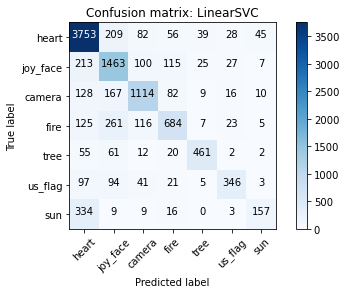

In [47]:
# 1st model: Linear Support Vector Classification
from sklearn.svm import LinearSVC
p = {
    'clf__C': [1, 0.1, 0.01, 0.001, 0.0001],
    'clf__tol': [0.1, 0.01, 0.001]
}
emoji_predicted, emoji_predicted_bin, emoji_test_bin, emoji_names = ModelParamsEvaluation(f2_union, LinearSVC(), p, 'LinearSVC')

PredictionEvaluation(emoji_predicted_bin, emoji_test_bin, emoji_names, 'LinearSVC')


plot_confusion_matrix(confusion_matrix(emoji_class_test, emoji_predicted),
                      emoji_names,
                      title='Confusion matrix: LinearSVC',
                      cmap=plt.cm.Blues)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  1.5min finished


Best score: 0.736
Best parameters set:
	clf__alpha: 0.0001
	clf__penalty: 'l2'
              precision    recall  f1-score   support

       heart       0.90      0.79      0.84      4785
    joy_face       0.73      0.66      0.70      2163
      camera       0.73      0.75      0.74      1483
        fire       0.55      0.70      0.62       963
        tree       0.77      0.83      0.80       574
     us_flag       0.60      0.75      0.67       491
         sun       0.25      0.68      0.37       198

   micro avg       0.75      0.75      0.75     10657
   macro avg       0.65      0.74      0.68     10657
weighted avg       0.78      0.75      0.76     10657
 samples avg       0.75      0.75      0.75     10657



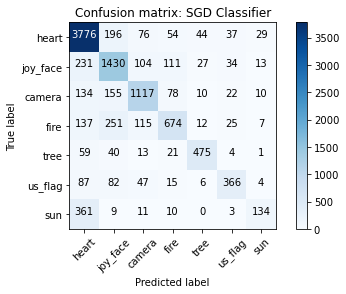

In [48]:
# 2nd model: Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier
p = {
    'clf__alpha': [0.01,0.001,0.0001,0.00001, 0.000001],
    'clf__penalty': ['l1','l2', 'elasticnet']
}
emoji_predicted, emoji_predicted_bin, emoji_test_bin, emoji_names = ModelParamsEvaluation (f2_union, SGDClassifier(), p, 'SGD Classifier')

PredictionEvaluation(emoji_predicted_bin, emoji_test_bin, emoji_names,'SGD Classifier')


plot_confusion_matrix(confusion_matrix(emoji_class_test, emoji_predicted), emoji_names,
                          title='Confusion matrix: SGD Classifier',
                          cmap=plt.cm.Blues)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   28.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   28.9s finished


Best score: 0.698
Best parameters set:
	clf__alpha: 0.1
              precision    recall  f1-score   support

       heart       0.80      0.81      0.80      4163
    joy_face       0.64      0.66      0.65      1896
      camera       0.70      0.72      0.71      1468
        fire       0.53      0.60      0.56      1075
        tree       0.75      0.80      0.77       573
     us_flag       0.64      0.59      0.61       657
         sun       0.60      0.39      0.47       825

   micro avg       0.70      0.70      0.70     10657
   macro avg       0.67      0.65      0.66     10657
weighted avg       0.70      0.70      0.70     10657
 samples avg       0.70      0.70      0.70     10657



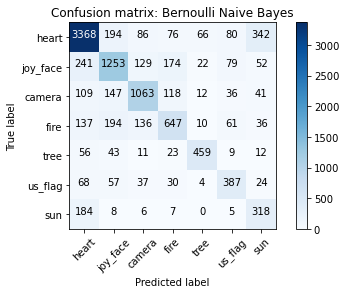

In [49]:
# 3rd model: Bernoulli Naive Bayes
from sklearn.naive_bayes import BernoulliNB
p = {
    'clf__alpha': [1, 0.1, 0.01, 0.001, 0.0001, 0]
}
emoji_predicted, emoji_predicted_bin, emoji_test_bin, emoji_names = ModelParamsEvaluation(f2_union,BernoulliNB(),p,'Bernoulli Naive Bayes')

PredictionEvaluation(emoji_predicted_bin, emoji_test_bin, emoji_names,'Bernoulli Naive Bayes')

plot_confusion_matrix(confusion_matrix(emoji_class_test, emoji_predicted), emoji_names,
                          title='Confusion matrix: Bernoulli Naive Bayes',
                          cmap=plt.cm.Blues)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.4min finished


Best score: 0.732
Best parameters set:
	clf__C: 1
	clf__solver: 'sag'
              precision    recall  f1-score   support

       heart       0.89      0.80      0.84      4648
    joy_face       0.74      0.64      0.69      2269
      camera       0.72      0.75      0.74      1466
        fire       0.57      0.67      0.61      1045
        tree       0.72      0.86      0.78       514
     us_flag       0.58      0.78      0.66       447
         sun       0.35      0.70      0.47       268

   micro avg       0.75      0.75      0.75     10657
   macro avg       0.65      0.74      0.69     10657
weighted avg       0.77      0.75      0.75     10657
 samples avg       0.75      0.75      0.75     10657



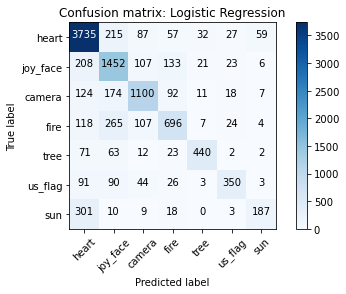

In [50]:
# 4th model: Logistic Regression
from sklearn.linear_model import LogisticRegression
p = {'clf__C': [1, 0.1, 0.01, 0.001, 0.0001],
     'clf__solver': ['sag','saga']}

emoji_predicted, emoji_predicted_bin, emoji_test_bin, emoji_names = ModelParamsEvaluation(f2_union,LogisticRegression(),p,'Logistic Regression')

PredictionEvaluation(emoji_predicted_bin, emoji_test_bin, emoji_names,'Logistic Regression')

plot_confusion_matrix(confusion_matrix(emoji_class_test, emoji_predicted), emoji_names,
                          title='Confusion matrix: Logistic Regression',
                          cmap=plt.cm.Blues)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:  3.1min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  4.0min finished


Best score: 0.670
Best parameters set:
	clf__criterion: 'gini'
	clf__max_features: 'sqrt'
              precision    recall  f1-score   support

       heart       0.93      0.65      0.76      6098
    joy_face       0.59      0.62      0.60      1871
      camera       0.64      0.74      0.69      1335
        fire       0.30      0.75      0.43       486
        tree       0.70      0.84      0.76       515
     us_flag       0.39      0.87      0.54       276
         sun       0.12      0.80      0.20        76

   micro avg       0.67      0.67      0.67     10657
   macro avg       0.53      0.75      0.57     10657
weighted avg       0.78      0.67      0.70     10657
 samples avg       0.67      0.67      0.67     10657



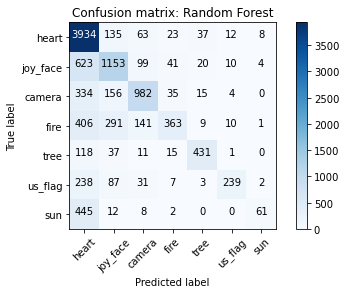

In [51]:
# 5th model: Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
p = {
    'clf__max_features': ['sqrt', 'log2'],
     'clf__criterion': ['gini', 'entropy']
}

emoji_predicted, emoji_predicted_bin, emoji_test_bin, emoji_names = ModelParamsEvaluation(f2_union, RandomForestClassifier(), p, 'Random Forest')

PredictionEvaluation(emoji_predicted_bin, emoji_test_bin, emoji_names, 'Random Forest')

plot_confusion_matrix(confusion_matrix(emoji_class_test, emoji_predicted), emoji_names,
                          title='Confusion matrix: Random Forest',
                          cmap=plt.cm.Blues)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.0min finished
C:\Users\Max\anaconda3\lib\site-packages\sklearn\neighbors\_base.py:415: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "


Best score: 0.493
Best parameters set:
	clf__algorithm: 'ball_tree'
	clf__weights: 'distance'
              precision    recall  f1-score   support

       heart       0.74      0.53      0.62      5817
    joy_face       0.36      0.45      0.40      1535
      camera       0.28      0.45      0.34       926
        fire       0.30      0.44      0.36       829
        tree       0.55      0.56      0.55       599
     us_flag       0.41      0.47      0.44       531
         sun       0.25      0.31      0.27       420

   micro avg       0.50      0.50      0.50     10657
   macro avg       0.41      0.46      0.43     10657
weighted avg       0.56      0.50      0.52     10657
 samples avg       0.50      0.50      0.50     10657



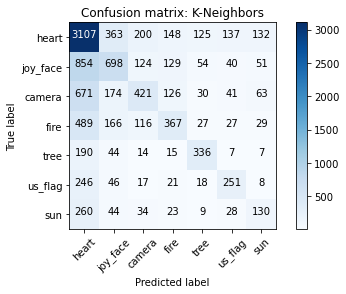

In [52]:
# 6th model: K-nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
p = {
    'clf__weights': ['uniform', 'distance'],
    'clf__algorithm': ['ball_tree', 'kd_tree', 'brute']
}

emoji_predicted, emoji_predicted_bin, emoji_test_bin, emoji_names = ModelParamsEvaluation(f2_union, KNeighborsClassifier(), p, 'K-Neighbors')

PredictionEvaluation(emoji_predicted_bin, emoji_test_bin, emoji_names, 'K-Neighbors')

plot_confusion_matrix(confusion_matrix(emoji_class_test, emoji_predicted), emoji_names,
                          title='Confusion matrix: K-Neighbors',
                          cmap=plt.cm.Blues)

In [53]:
# print final score and ranking of models
df_ScoreSummaryByModelParams=pd.DataFrame(ScoreSummaryByModelParams,columns=['Method','BestScore','BestParameter'])
df_ScoreSummaryByModelParams.sort_values(['BestScore'], ascending=False, inplace=True)
print(df_ScoreSummaryByModelParams)

df_ScoreSummaryByModel=pd.DataFrame(ScoreSummaryByModel,columns=['Precision','Accuracy','Recall','F1','Comment'])
df_ScoreSummaryByModel.sort_values(['F1'],ascending=False,inplace=True)
print(df_ScoreSummaryByModel)

                   Method  BestScore                  BestParameter
2          SGD Classifier   0.735684           \tclf__alpha: 0.0001
3          SGD Classifier   0.735684           \tclf__penalty: 'l2'
0               LinearSVC   0.735238                  \tclf__C: 0.1
1               LinearSVC   0.735238               \tclf__tol: 0.01
5     Logistic Regression   0.732447                    \tclf__C: 1
6     Logistic Regression   0.732447           \tclf__solver: 'sag'
4   Bernoulli Naive Bayes   0.698032              \tclf__alpha: 0.1
7           Random Forest   0.670115       \tclf__criterion: 'gini'
8           Random Forest   0.670115    \tclf__max_features: 'sqrt'
9             K-Neighbors   0.492528  \tclf__algorithm: 'ball_tree'
10            K-Neighbors   0.492528     \tclf__weights: 'distance'
   Precision  Accuracy    Recall        F1                Comment
0   0.748616  0.721940  0.732873  0.724097              LinearSVC
1   0.748053  0.725838  0.728451  0.723601         S